## Notebook Objectives

- Summarize each dataset's coverage, missingness, and basic stats.
- Diagnose stationarity and temporal structure (rolling stats, ACF/PACF, decomposition).
- Persist reusable reports and figures under `eda/reports` for later modeling phases.

In [6]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display
from pandas.tseries.frequencies import to_offset
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 120
%matplotlib inline

In [7]:
try:
    ROOT = Path(__file__).resolve().parents[1]
except NameError:
    ROOT = Path.cwd()

if not (ROOT / "daily-minimum-temperatures-in-me.csv").exists():
    ROOT = ROOT.parent

DATA_DIR = ROOT
OUTPUT_DIR = ROOT / "eda" / "reports"
FIGURES_DIR = OUTPUT_DIR / "figures"

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

display(Markdown(f"**Working directory:** `{ROOT}`"))
display(Markdown(f"**Reports folder:** `{OUTPUT_DIR}`"))

**Working directory:** `/Users/karan/Documents/Advanced-Data-Analytics`

**Reports folder:** `/Users/karan/Documents/Advanced-Data-Analytics/eda/reports`

In [8]:
def _parse_shampoo_label(label: str) -> pd.Timestamp:
    year_token, month_token = label.split("-")
    year = 2000 + int(year_token) - 1
    return pd.to_datetime(f"{year}-{month_token}", format="%Y-%b")

DATASETS = {
    "daily-minimum-temperatures-in-me.csv": {
        "date_col": "Date",
        "parse_fn": lambda s: pd.to_datetime(s, format="%m/%d/%Y"),
        "value_cols": ["Daily minimum temperatures"],
        "freq": "D",
        "target_col": "Daily minimum temperatures",
        "title": "Daily Minimum Temperatures (Melbourne)",
    },
    "Electric_Production.csv": {
        "date_col": "DATE",
        "parse_fn": lambda s: pd.to_datetime(s, format="%m/%d/%Y"),
        "value_cols": ["IPG2211A2N"],
        "freq": "MS",
        "target_col": "IPG2211A2N",
        "title": "Monthly Electric Production (USA)",
    },
    "monthly-beer-production-in-austr.csv": {
        "date_col": "Month",
        "parse_fn": lambda s: pd.to_datetime(s, format="%Y-%m"),
        "value_cols": ["Monthly beer production"],
        "freq": "MS",
        "target_col": "Monthly beer production",
        "title": "Monthly Beer Production (Australia)",
    },
    "sales-of-shampoo-over-a-three-ye.csv": {
        "date_col": "Month",
        "parse_fn": lambda s: s.map(_parse_shampoo_label),
        "value_cols": ["Sales of shampoo over a three year period"],
        "freq": "MS",
        "target_col": "Sales of shampoo over a three year period",
        "title": "Shampoo Sales (Synthetic 3-Year Series)",
    },
    "LSTM-Multivariate_pollution.csv": {
        "date_col": "date",
        "parse_fn": lambda s: pd.to_datetime(s, format="%Y-%m-%d %H:%M:%S"),
        "value_cols": [
            "pollution",
            "dew",
            "temp",
            "press",
            "wnd_spd",
            "snow",
            "rain",
        ],
        "categorical_cols": ["wnd_dir"],
        "freq": "H",
        "target_col": "pollution",
        "title": "Beijing PM2.5 and Weather (Multivariate)",
    },
}

In [9]:
def load_dataset(dataset_name: str, info: dict) -> pd.DataFrame:
    df = pd.read_csv(DATA_DIR / dataset_name)
    parse_fn = info["parse_fn"]
    date_col = info["date_col"]
    df[date_col] = parse_fn(df[date_col])
    df = df.set_index(date_col).sort_index()
    df = df[~df.index.duplicated(keep="first")]

    value_cols = info.get("value_cols", [])
    for col in value_cols:
        series = df[col].astype(str).str.strip()
        series = series.replace({"": np.nan, "nan": np.nan})
        series = series.str.replace(r"[^0-9.+-]", "", regex=True)
        series = series.replace({"": np.nan})
        df[col] = pd.to_numeric(series, errors="coerce")

    return df


Processing daily-minimum-temperatures-in-me.csv...


### Daily Minimum Temperatures (Melbourne)

- Observations: 3,650

- Time span: 1981-01-01T00:00:00 → 1990-12-31T00:00:00

- Missing values by column:

,missing
Daily minimum temperatures,0


- Preview:

,Daily minimum temperatures
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


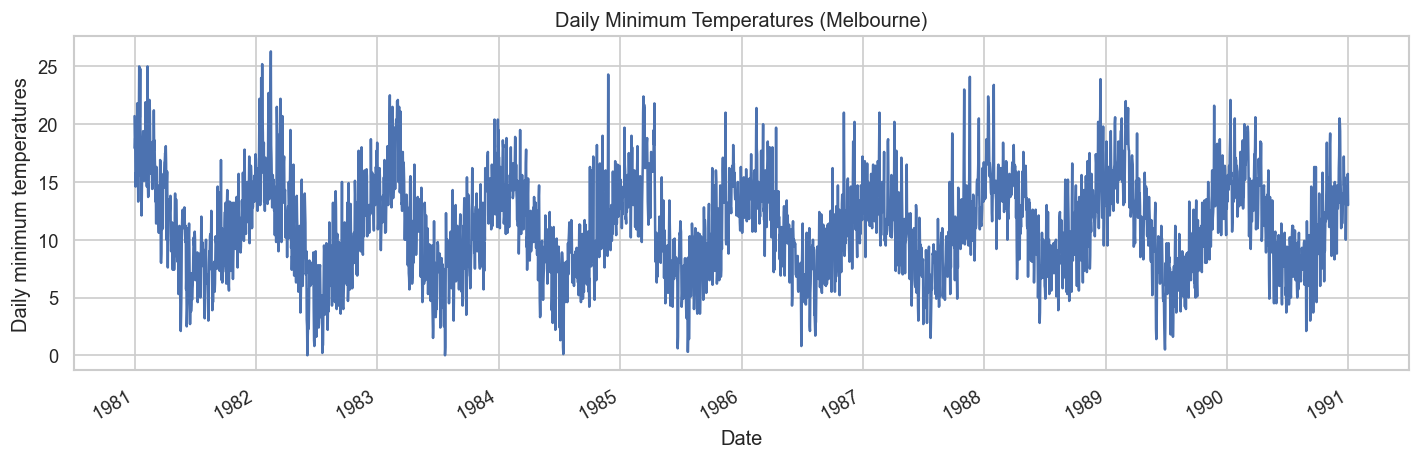

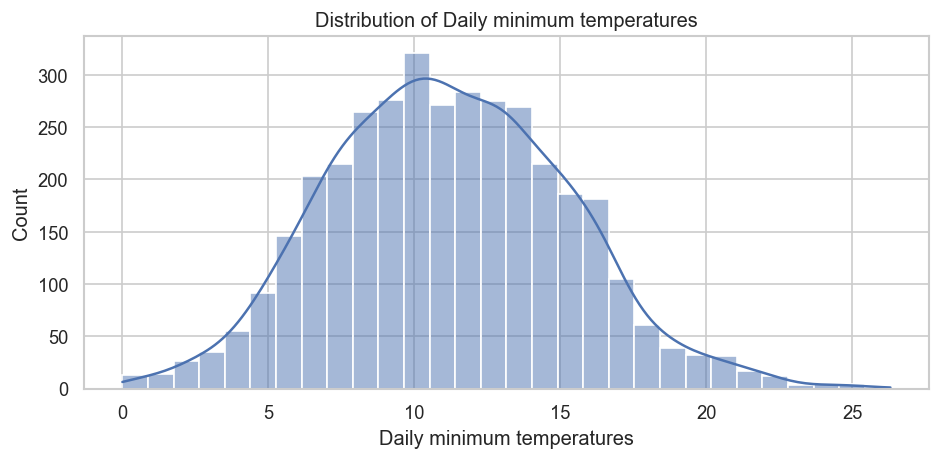

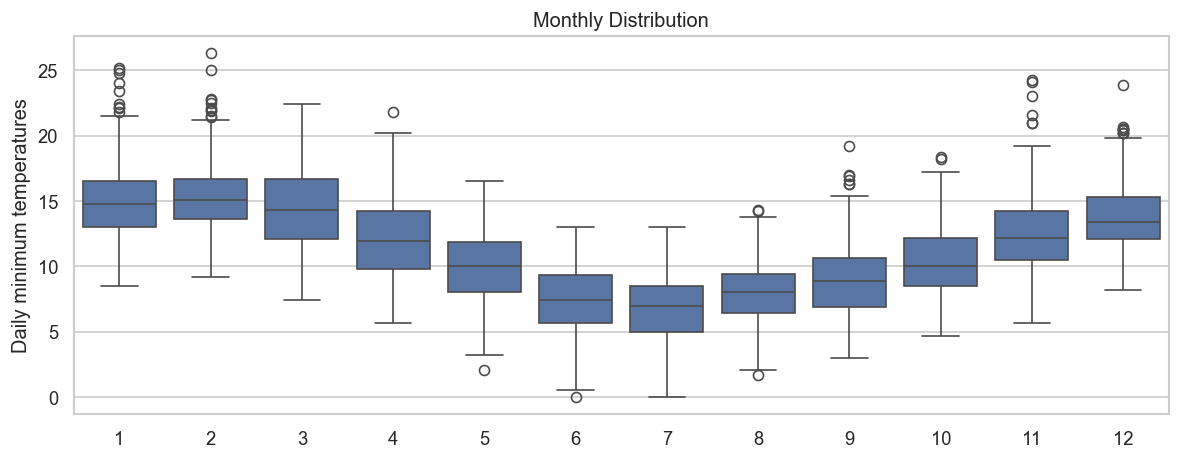

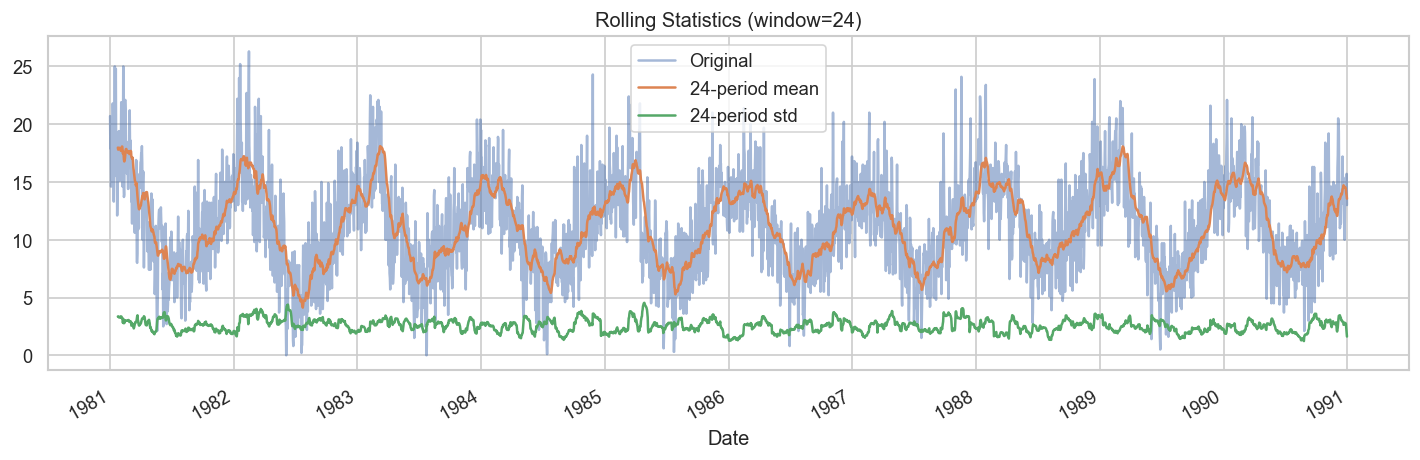

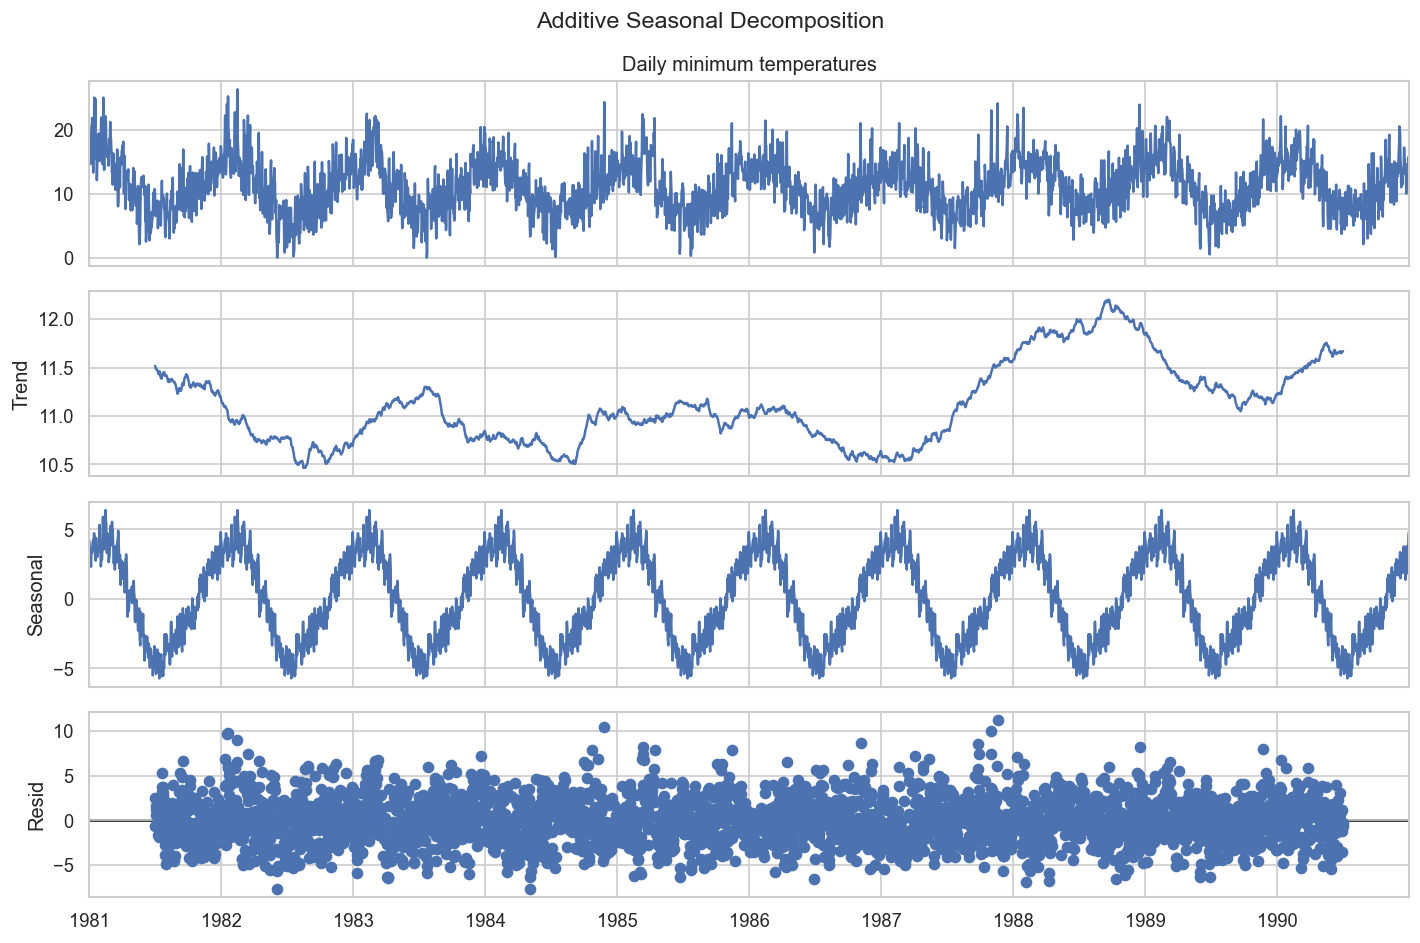

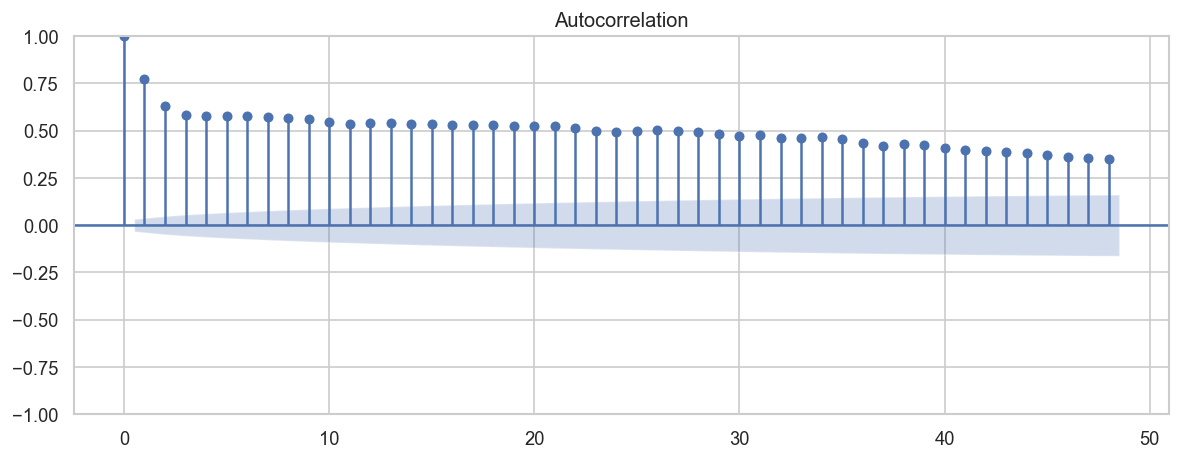

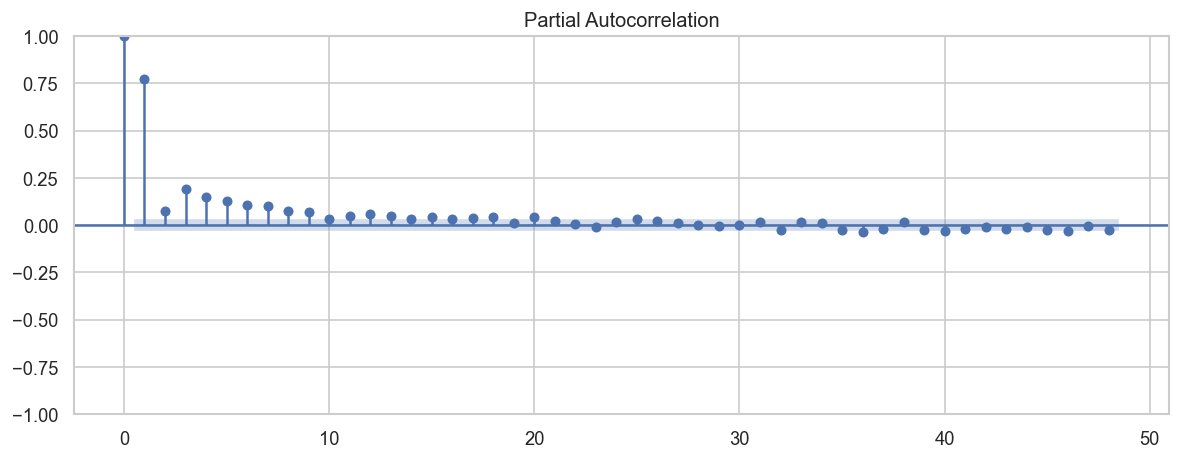

- Univariate diagnostics:

,count,mean,std,min,25%,50%,75%,max,missing,missing_pct,min_timestamp,max_timestamp,inferred_freq,adf_adf_statistic,adf_pvalue,adf_n_lags,adf_n_obs
0,3650.0,11.177753,4.071837,0.0,8.3,11.0,14.0,26.3,0,0.0,1981-01-01T00:00:00,1990-12-31T00:00:00,D,-4.444805,0.000247,20,3629


Saved JSON report to `/Users/karan/Documents/Advanced-Data-Analytics/eda/reports/daily-minimum-temperatures-in-me_summary.json`

Processing Electric_Production.csv...


### Monthly Electric Production (USA)

- Observations: 397

- Time span: 1985-01-01T00:00:00 → 2018-01-01T00:00:00

- Missing values by column:

,missing
IPG2211A2N,0


- Preview:

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


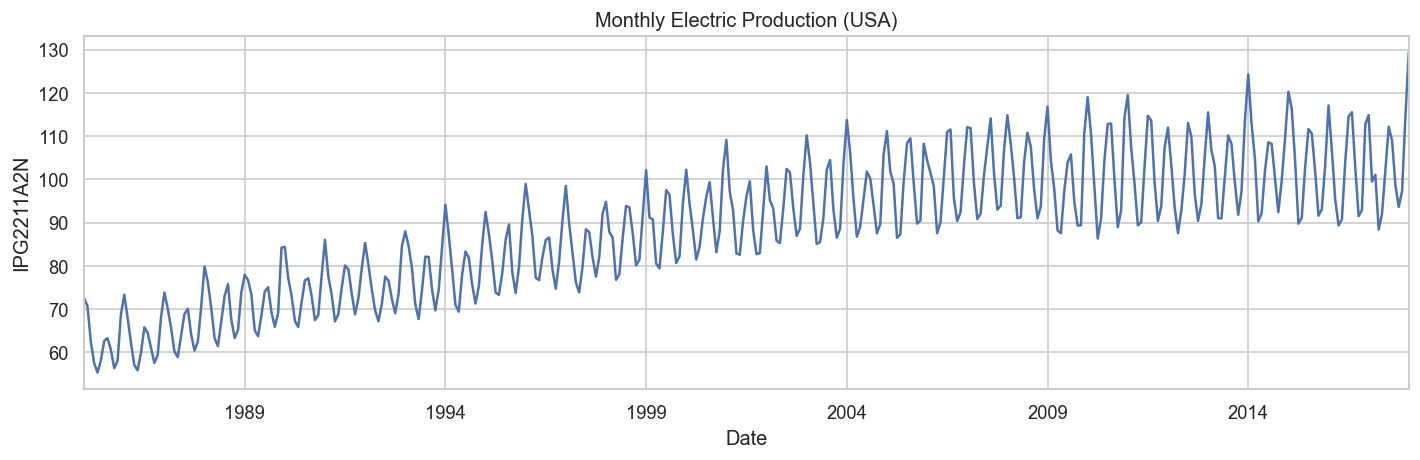

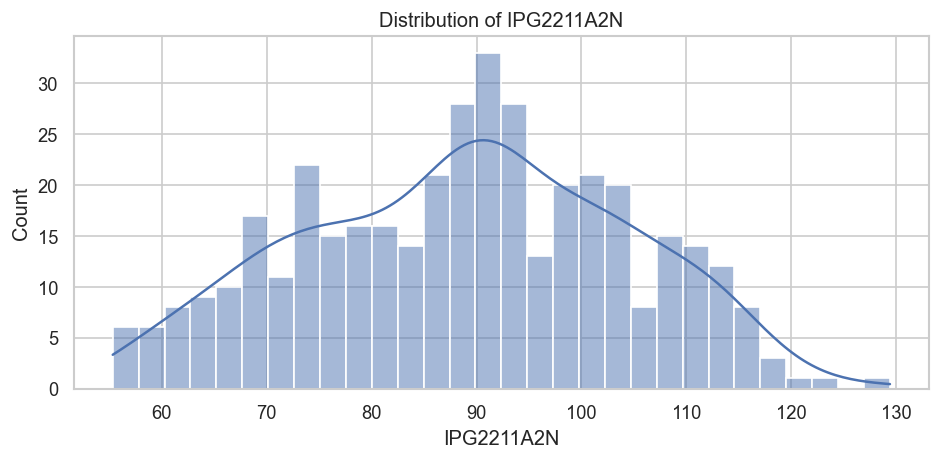

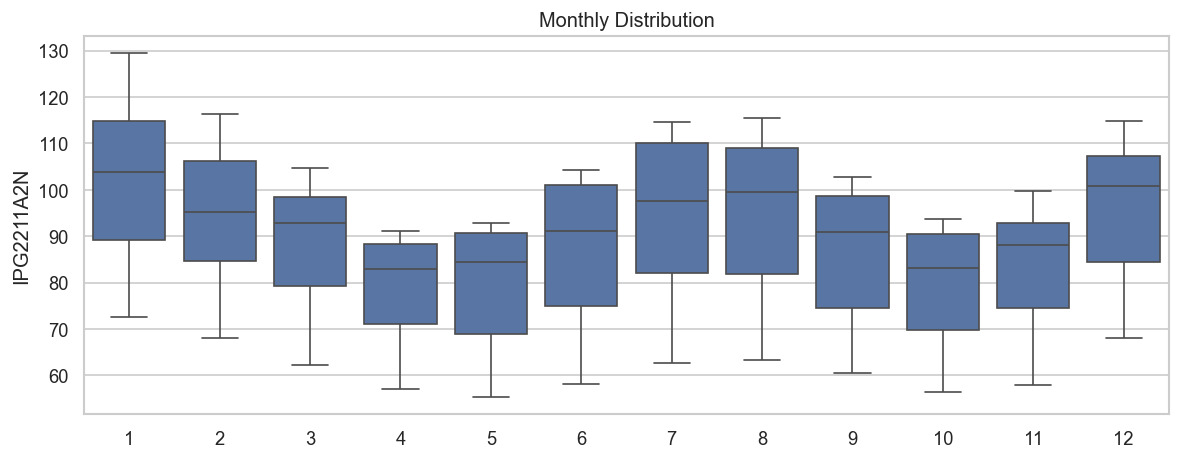

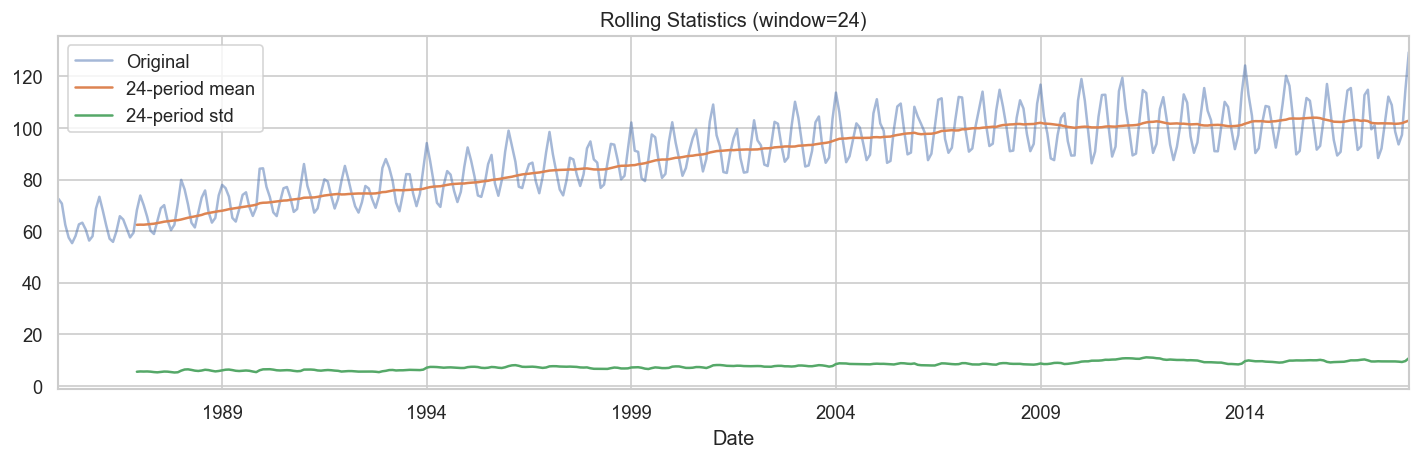

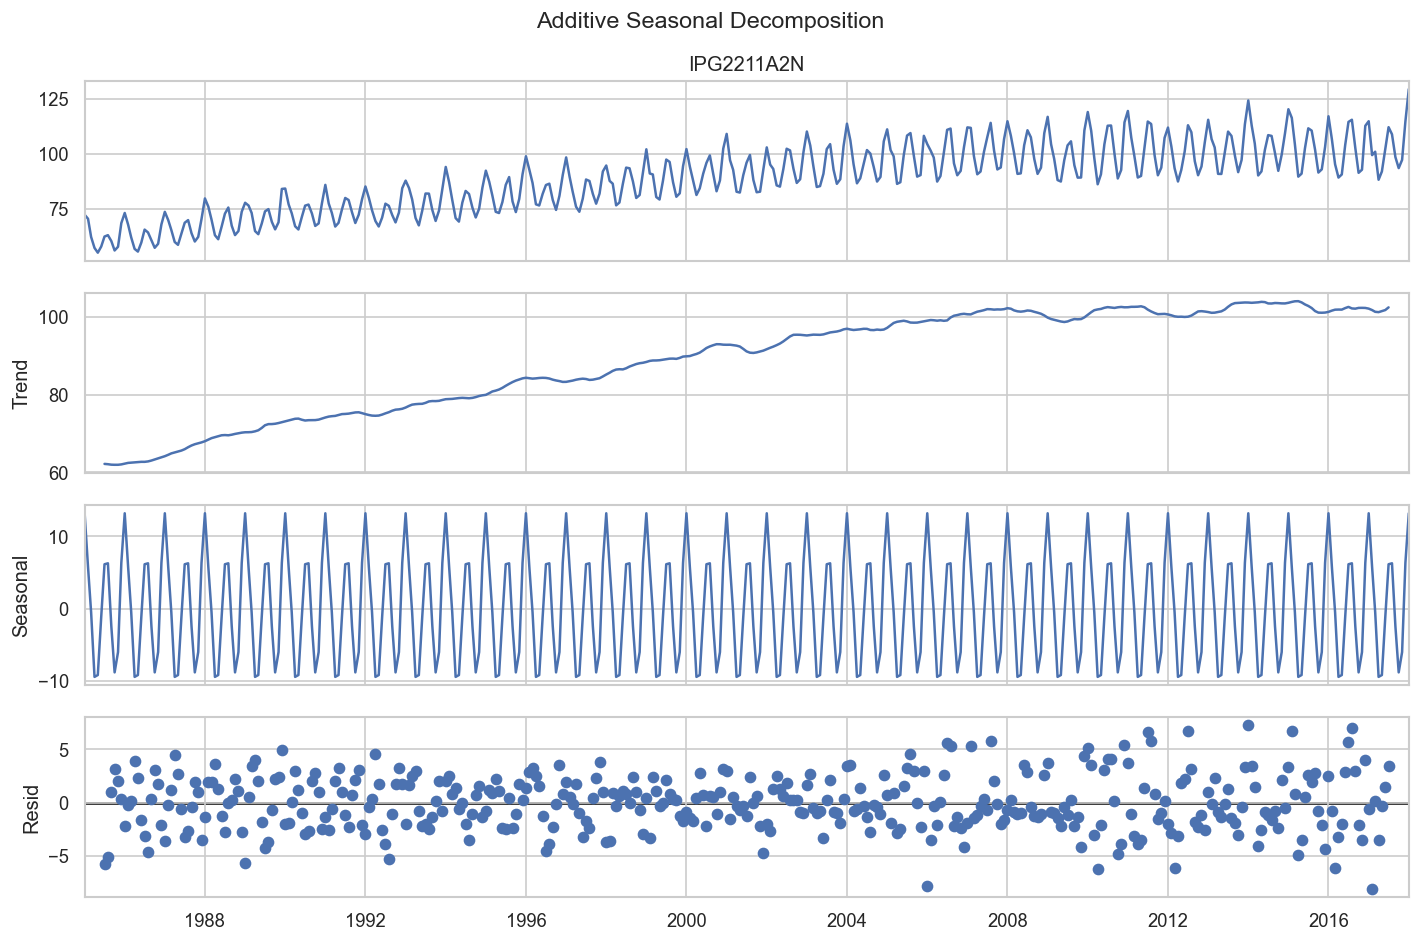

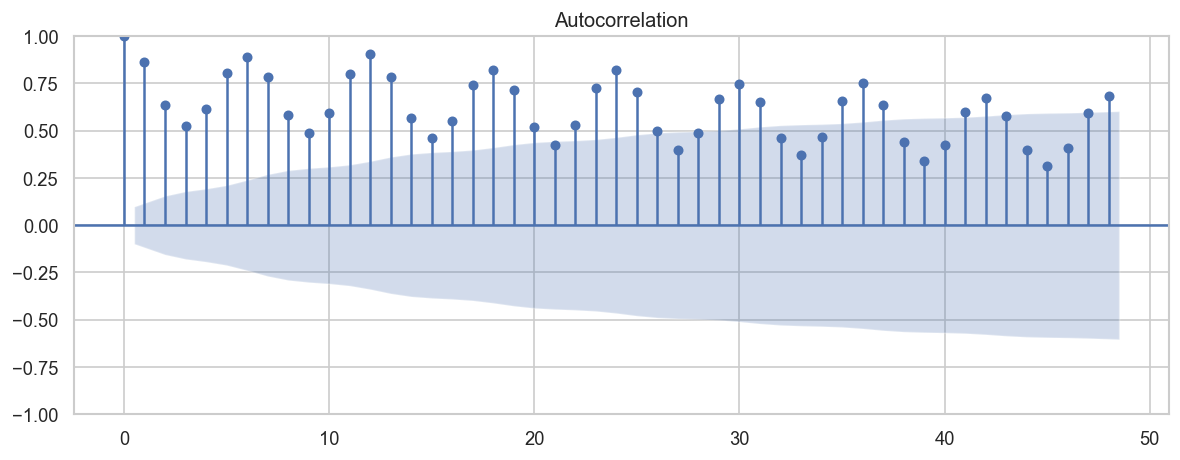

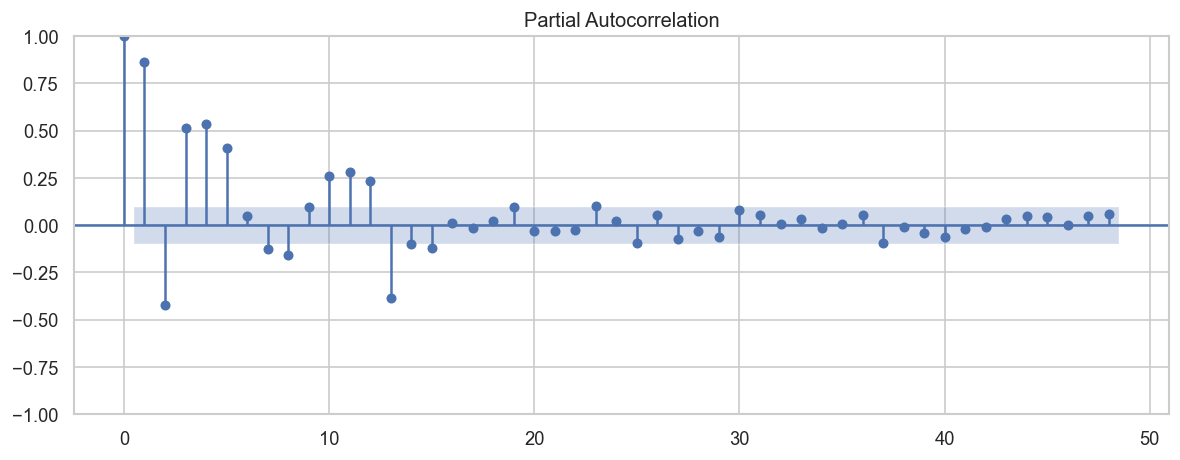

- Univariate diagnostics:

,count,mean,std,min,25%,50%,75%,max,missing,missing_pct,min_timestamp,max_timestamp,inferred_freq,adf_adf_statistic,adf_pvalue,adf_n_lags,adf_n_obs
0,397.0,88.847218,15.387834,55.3151,77.1052,89.7795,100.5244,129.4048,0,0.0,1985-01-01T00:00:00,2018-01-01T00:00:00,MS,-2.25699,0.186215,15,381


Saved JSON report to `/Users/karan/Documents/Advanced-Data-Analytics/eda/reports/Electric_Production_summary.json`

Processing monthly-beer-production-in-austr.csv...


### Monthly Beer Production (Australia)

- Observations: 476

- Time span: 1956-01-01T00:00:00 → 1995-08-01T00:00:00

- Missing values by column:

,missing
Monthly beer production,0


- Preview:

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


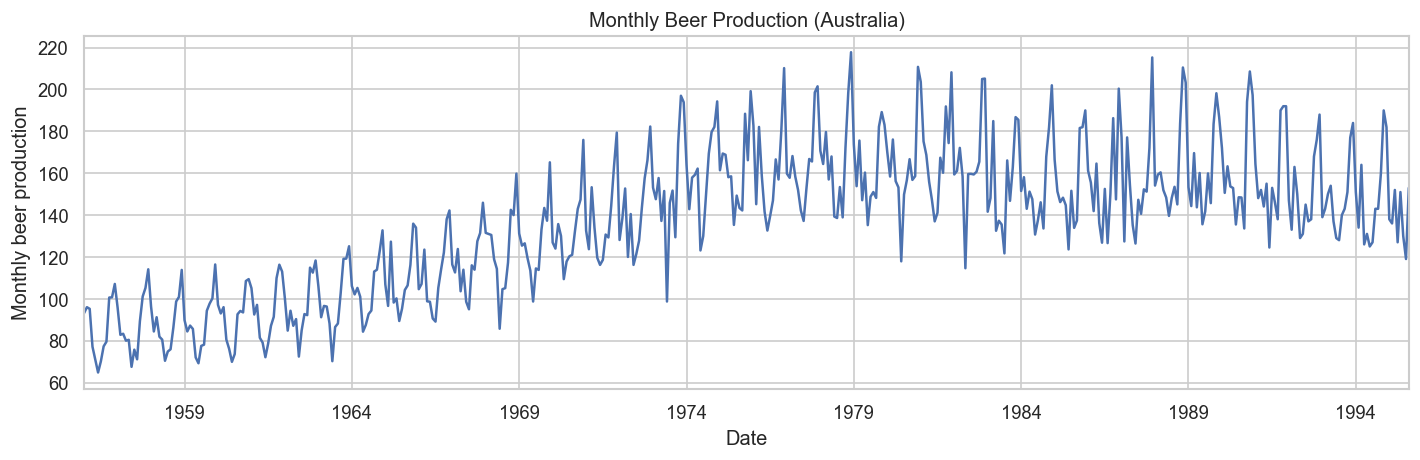

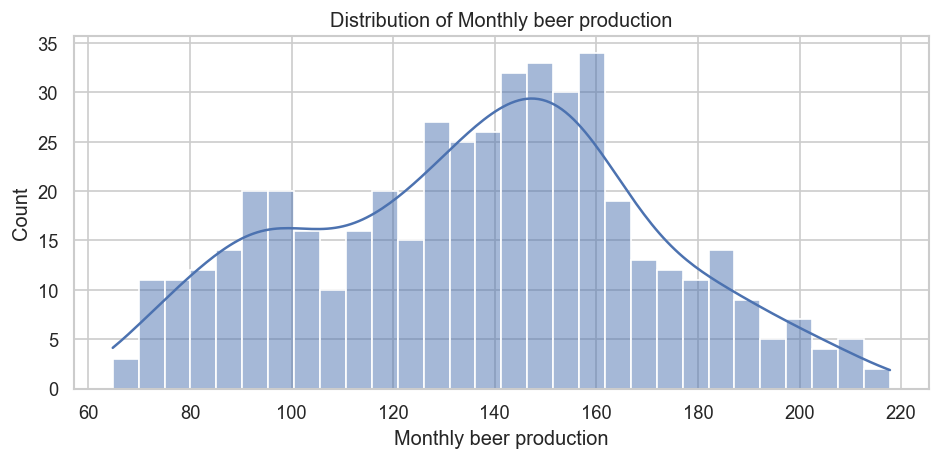

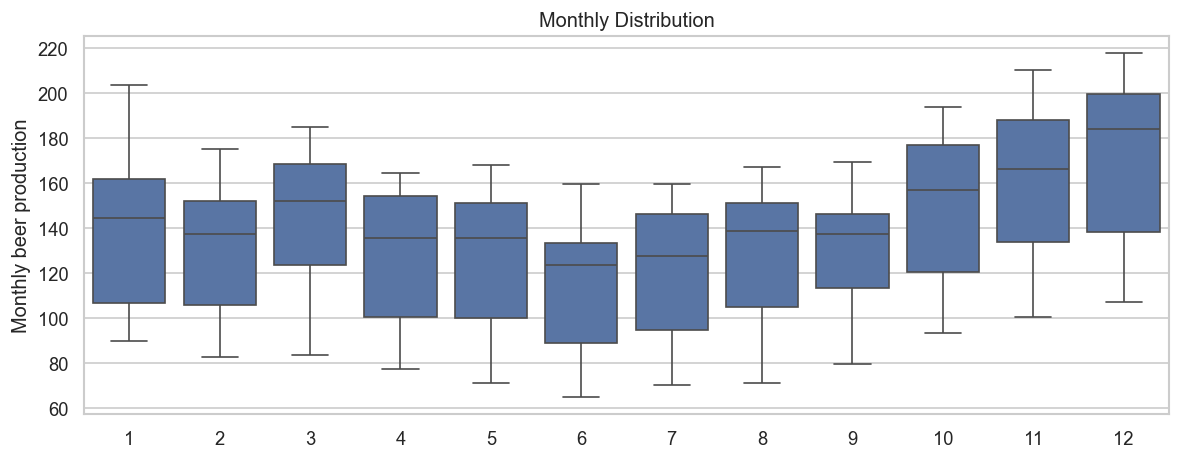

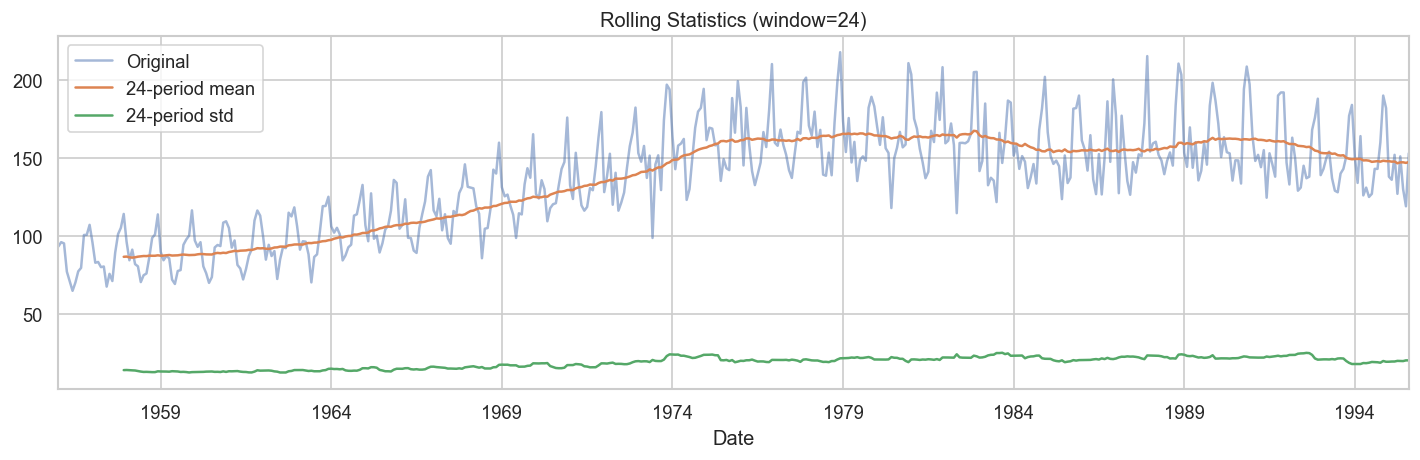

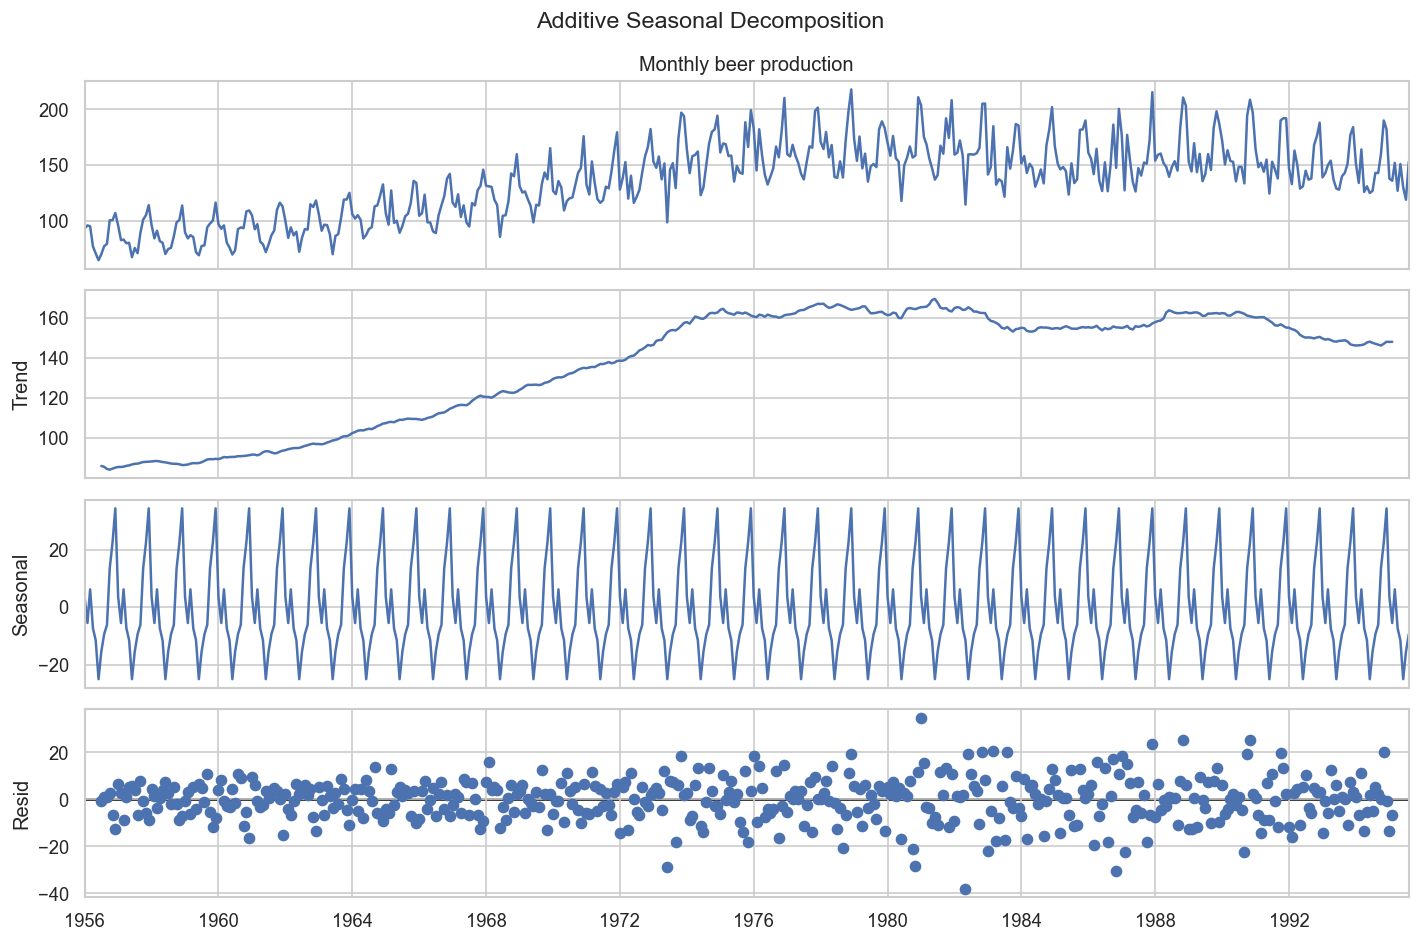

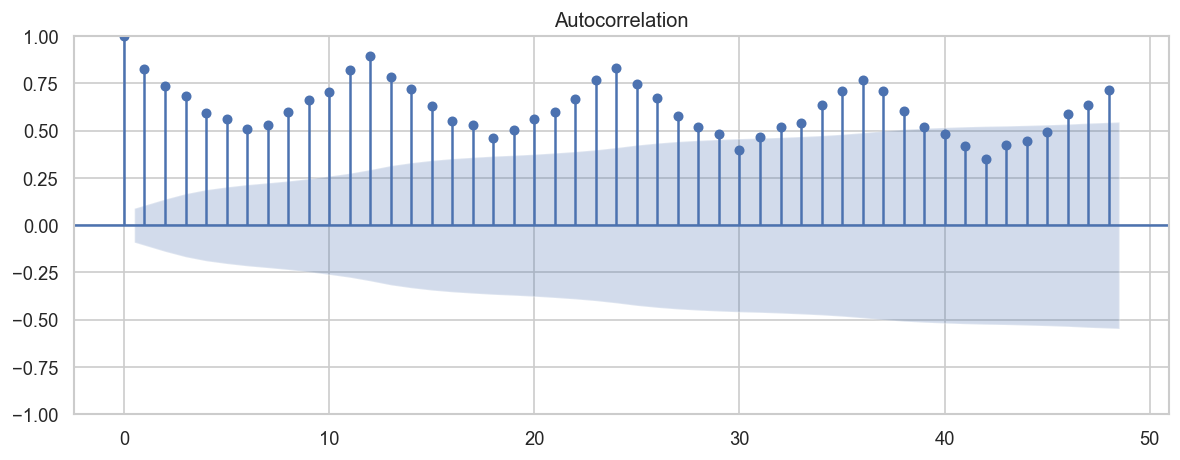

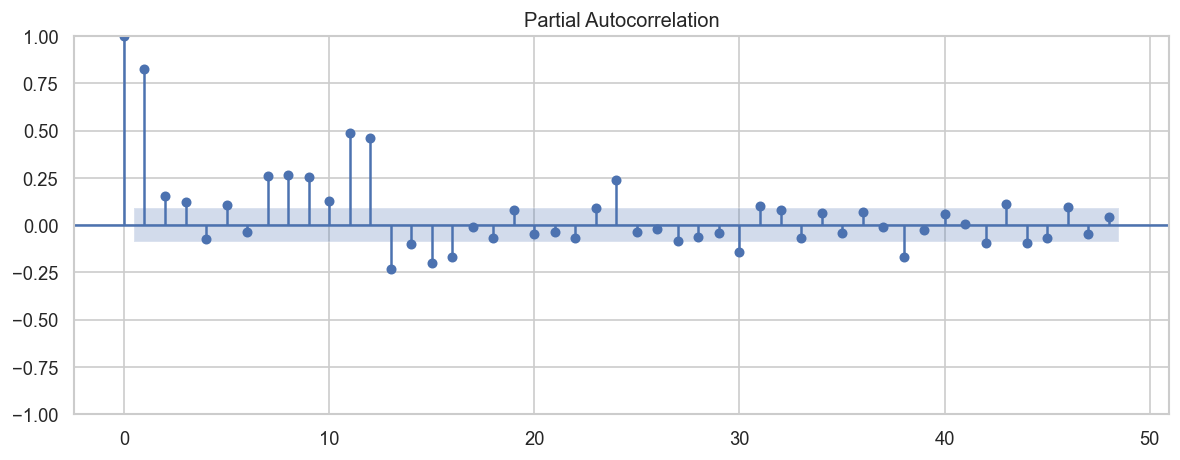

- Univariate diagnostics:

,count,mean,std,min,25%,50%,75%,max,missing,missing_pct,min_timestamp,max_timestamp,inferred_freq,adf_adf_statistic,adf_pvalue,adf_n_lags,adf_n_obs
0,476.0,136.395378,33.738725,64.8,112.9,139.15,158.825,217.8,0,0.0,1956-01-01T00:00:00,1995-08-01T00:00:00,MS,-2.282661,0.177621,17,458


Saved JSON report to `/Users/karan/Documents/Advanced-Data-Analytics/eda/reports/monthly-beer-production-in-austr_summary.json`

Processing sales-of-shampoo-over-a-three-ye.csv...


### Shampoo Sales (Synthetic 3-Year Series)

- Observations: 36

- Time span: 2000-01-01T00:00:00 → 2002-12-01T00:00:00

- Missing values by column:

,missing
Sales of shampoo over a three year period,0


- Preview:

,Sales of shampoo over a three year period
Month,
2000-01-01,266.0
2000-02-01,145.9
2000-03-01,183.1
2000-04-01,119.3
2000-05-01,180.3


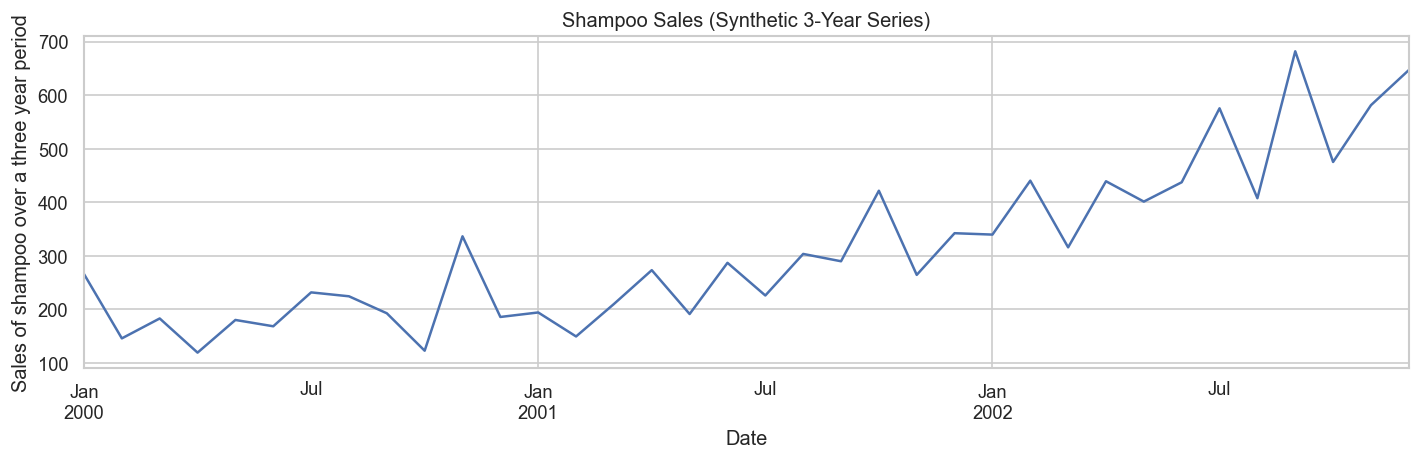

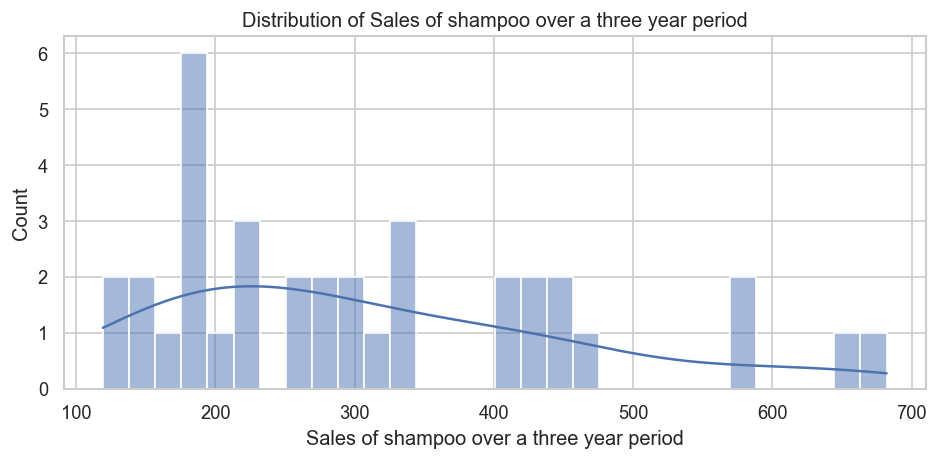

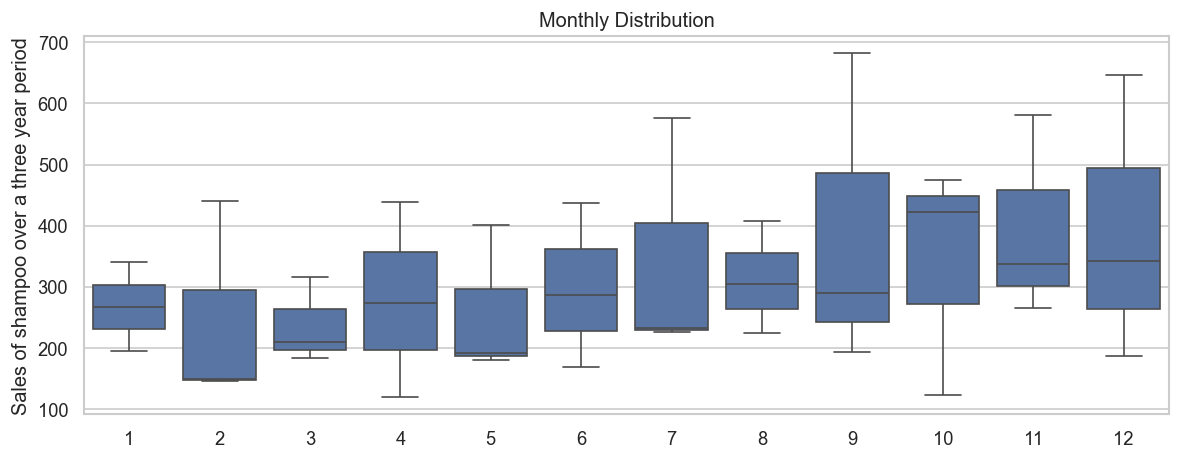

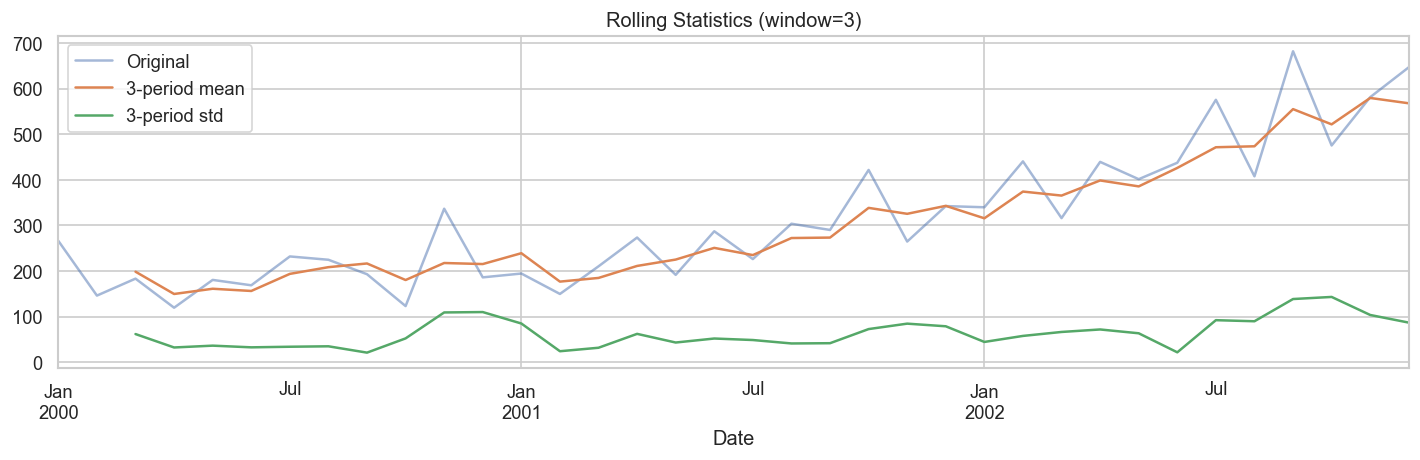

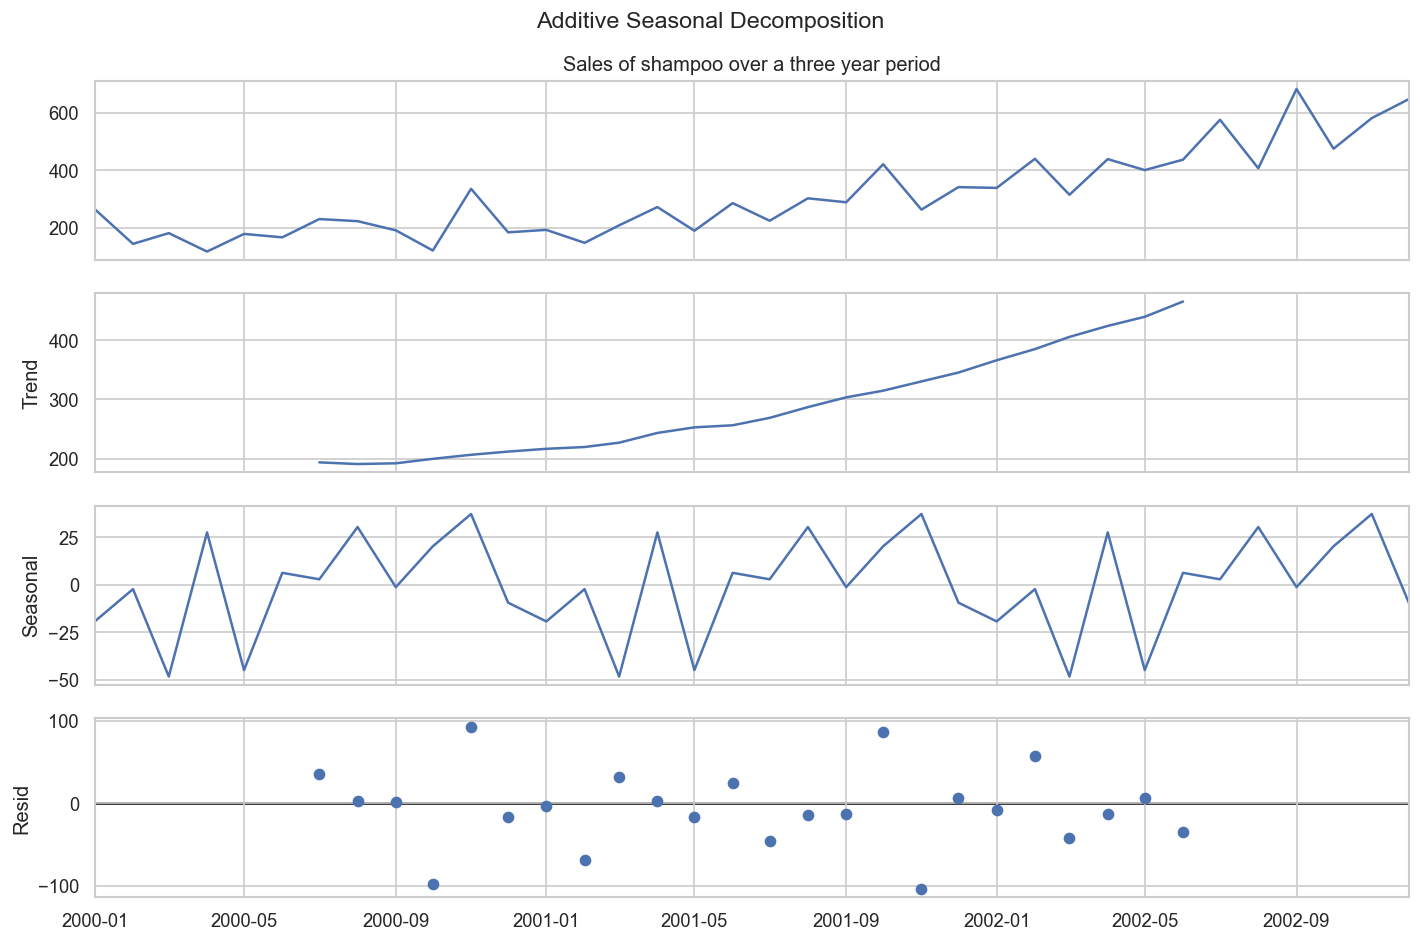

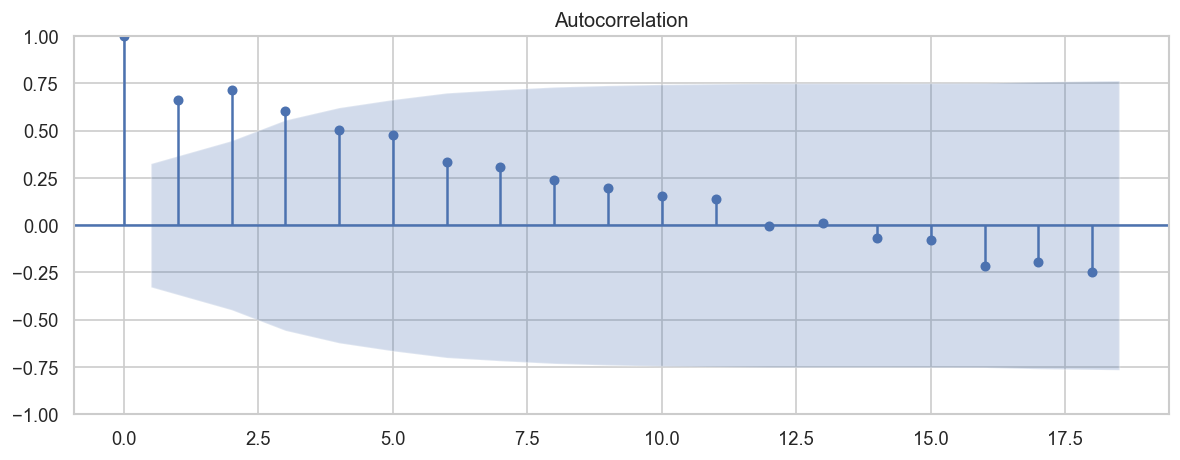

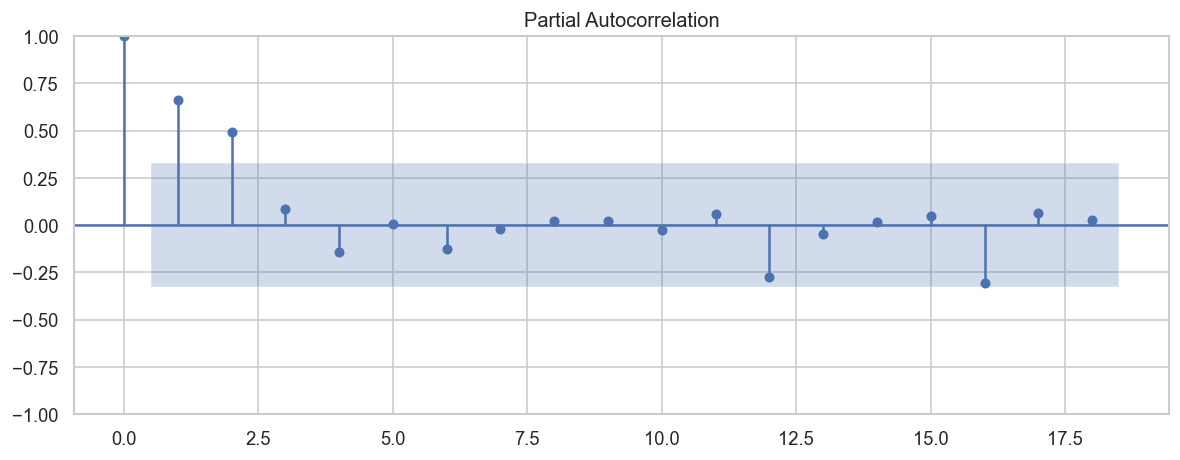

- Univariate diagnostics:

,count,mean,std,min,25%,50%,75%,max,missing,missing_pct,min_timestamp,max_timestamp,inferred_freq,adf_adf_statistic,adf_pvalue,adf_n_lags,adf_n_obs
0,36.0,312.6,148.937164,119.3,192.45,280.15,411.1,682.0,0,0.0,2000-01-01T00:00:00,2002-12-01T00:00:00,MS,3.060142,1.0,10,25


Saved JSON report to `/Users/karan/Documents/Advanced-Data-Analytics/eda/reports/sales-of-shampoo-over-a-three-ye_summary.json`

Processing LSTM-Multivariate_pollution.csv...


### Beijing PM2.5 and Weather (Multivariate)

- Observations: 43,800

- Time span: 2010-01-02T00:00:00 → 2014-12-31T23:00:00

- Missing values by column:

,missing
pollution,0
dew,0
temp,0
press,0
wnd_dir,0
wnd_spd,0
snow,0
rain,0


- Preview:

,pollution,dew,temp,press,wnd_spd,snow,rain
date,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0


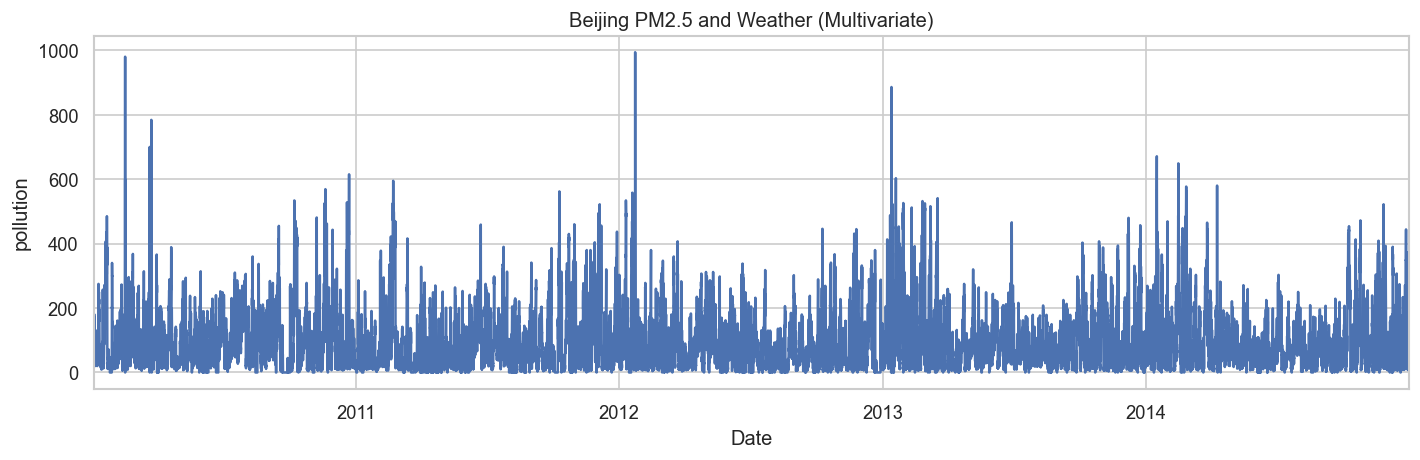

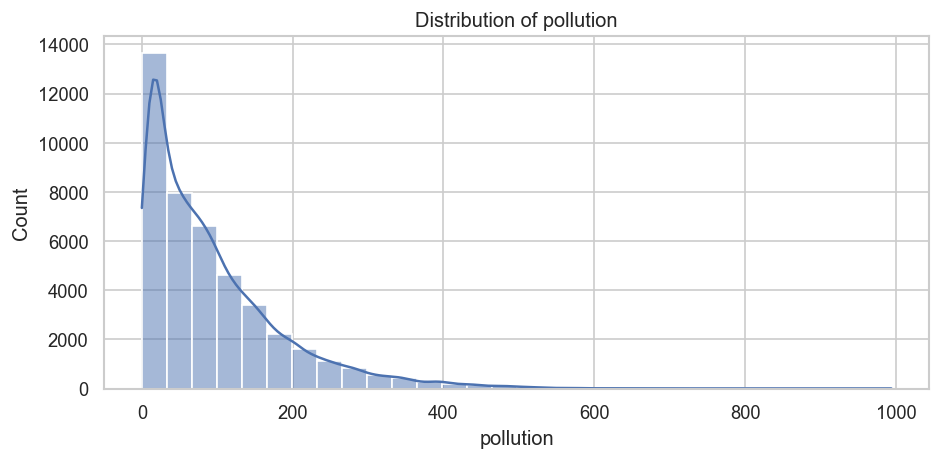

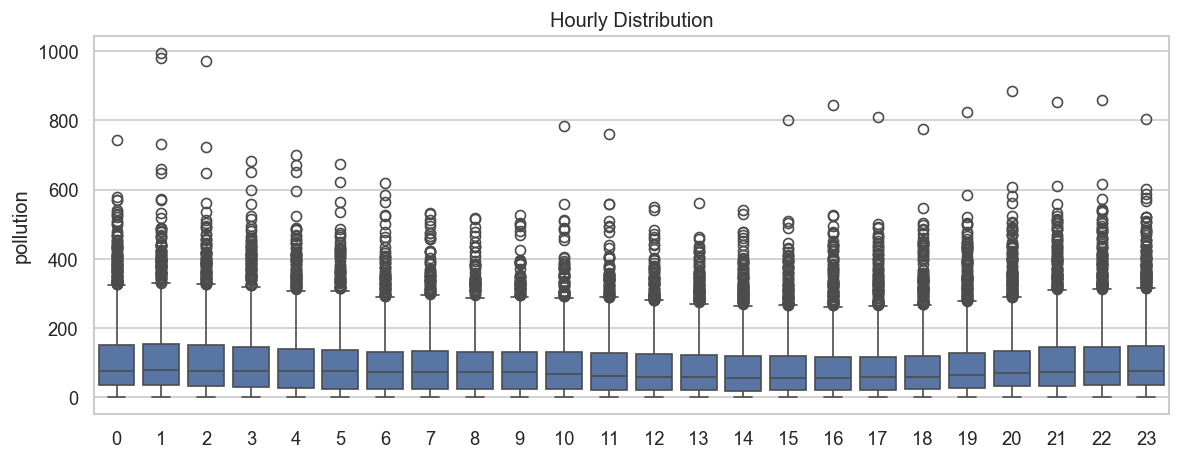

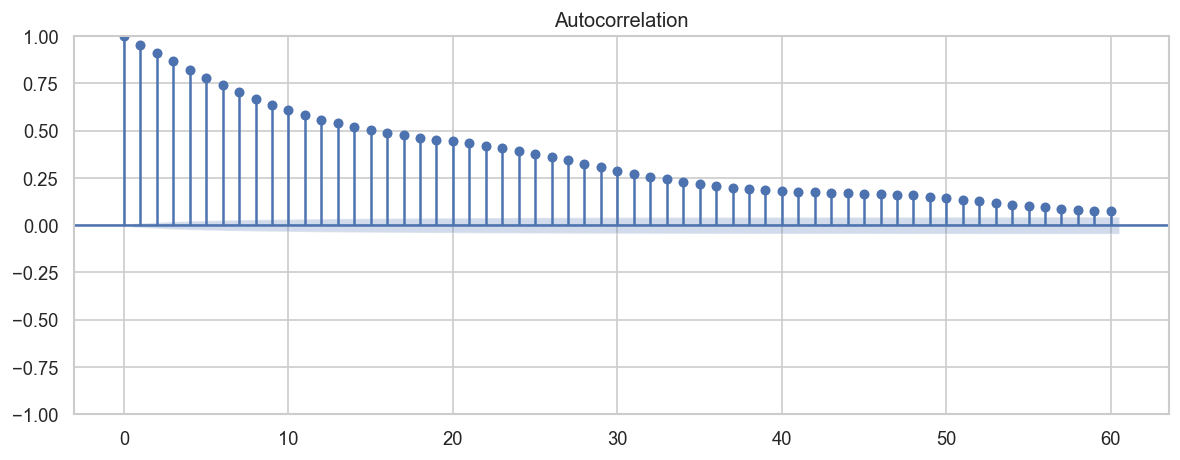

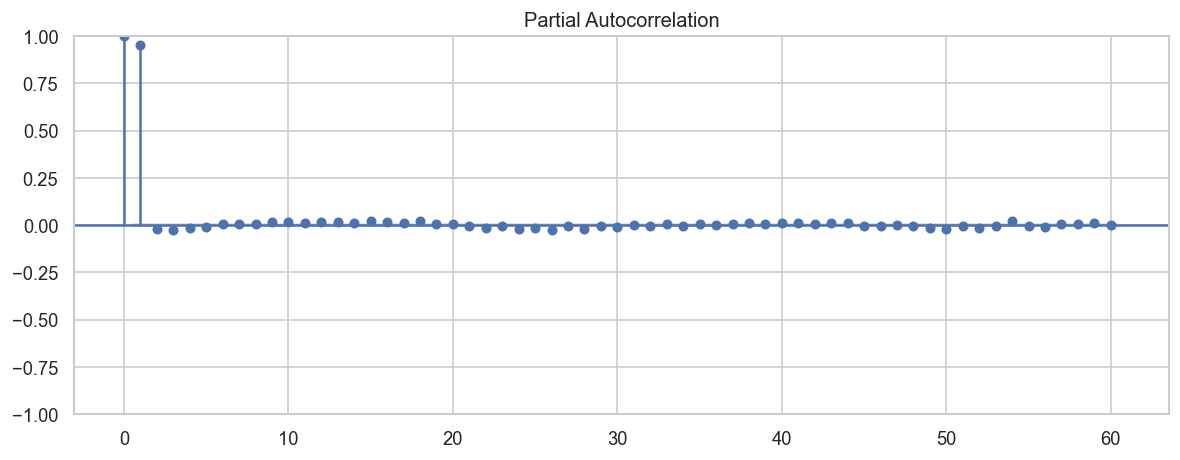

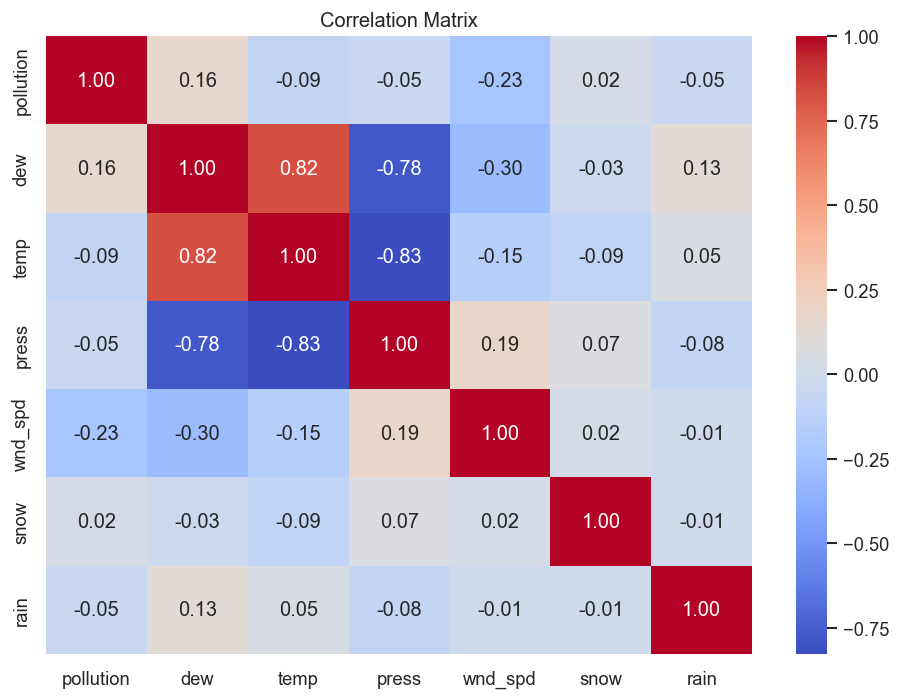

- Multivariate diagnostics:

,count,mean,std,min,25%,50%,75%,max,missing,missing_pct,min_timestamp,max_timestamp,inferred_freq,adf_adf_statistic,adf_pvalue,adf_n_lags,adf_n_obs
pollution,43800.0,94.013516,92.252276,0.0,24.0,68.0,132.25,994.0,0,0.0,2010-01-02T00:00:00,2014-12-31T23:00:00,H,-21.004109,0.0,55,43744
dew,43800.0,1.828516,14.429326,-40.0,-10.0,2.0,15.0,28.0,0,0.0,2010-01-02T00:00:00,2014-12-31T23:00:00,H,-6.122923,0.0,55,43744
temp,43800.0,12.459041,12.193384,-19.0,2.0,14.0,23.0,42.0,0,0.0,2010-01-02T00:00:00,2014-12-31T23:00:00,H,-3.938179,0.001771,49,43750
press,43800.0,1016.447306,10.271411,991.0,1008.0,1016.0,1025.0,1046.0,0,0.0,2010-01-02T00:00:00,2014-12-31T23:00:00,H,-7.392936,0.0,55,43744
wnd_spd,43800.0,23.894307,50.022729,0.45,1.79,5.37,21.91,585.6,0,0.0,2010-01-02T00:00:00,2014-12-31T23:00:00,H,-33.913549,0.0,5,43794
snow,43800.0,0.052763,0.760582,0.0,0.0,0.0,0.0,27.0,0,0.0,2010-01-02T00:00:00,2014-12-31T23:00:00,H,-27.343205,0.0,55,43744
rain,43800.0,0.195023,1.416247,0.0,0.0,0.0,0.0,36.0,0,0.0,2010-01-02T00:00:00,2014-12-31T23:00:00,H,-33.760937,0.0,22,43777


- Missing breakdown (numeric + categorical):

,missing
pollution,0
dew,0
temp,0
press,0
wnd_spd,0
snow,0
rain,0
wnd_dir,0


Saved JSON report to `/Users/karan/Documents/Advanced-Data-Analytics/eda/reports/LSTM-Multivariate_pollution_summary.json`

Notebook index saved to `/Users/karan/Documents/Advanced-Data-Analytics/eda/reports/eda_notebook_index.json`

In [10]:
reports = {}
for dataset_name, info in DATASETS.items():
    print(f"Processing {dataset_name}...")
    reports[dataset_name] = generate_report(dataset_name, info)

index_path = OUTPUT_DIR / "eda_notebook_index.json"
with index_path.open("w", encoding="utf-8") as fp:
    json.dump(reports, fp, indent=2, default=str)
display(Markdown(f"Notebook index saved to `{index_path}`"))

## Next Steps

- Review the figures under `eda/reports/figures/` for patterns worth modeling.
- Feed the JSON summaries into causal discovery notebooks to cross-check inferred structures.